<a href="https://colab.research.google.com/github/edgaracabral/Kaggle_BankMarketing/blob/main/04_Construcao_dos_Modelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kaggle Bank Marketing Case
## Construção de Modelos:

Neste fase temos como desafio:
* Treinar um modelo de classificação
 * Justificar escolha de modelo e otimização de parâmetros

## Framework de Construção de Modelos
 Usamos o framework de criação de modelos da PoD Academy, que consiste nos seguintes passos:


# 1. Definindo o Ambiente
* Google Drive
* Carregar Bibliotecas Utilizadas
* Definir Path dos arquivos

In [49]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, roc_auc_score

# Redirecione para o folder on pod_academy_functions.py is localizado
%cd /content/drive/MyDrive/PoD Academy/modelos/Hackaton_DS_2023/PoD Framework
import pod_academy_functions as pod

/content/drive/MyDrive/PoD Academy/modelos/Hackaton_DS_2023/PoD Framework


In [51]:
# Armazene o caminho do folder de DataPrep em file_path
file_path = '/content/drive/MyDrive/Kaggle/Bank\ Marketing/02\ data\ prep'

# Vá para o folder de DataPrep
%cd $file_path

/content/drive/MyDrive/Kaggle/Bank Marketing/02 data prep


#2. Carregando as ABTs de Treino e Teste

## 2.1 Carregando a ABT de Treino

In [52]:
abt_train_00 = pd.read_csv('abt_fs01_train.csv',index_col=0)
print(f"abt_train_00.shape = {abt_train_00.shape}")
abt_train_00.head()

abt_train_00.shape = (31647, 10)


,age,balance,day,duration,campaign,pdays,previous,poutcome_success,contact_unknown,target
0,-0.464799,-0.456680,0.140619,-0.404011,0.389277,-1.138504e-15,-0.240512,-0.185066,1.578328,0
1,1.416343,-0.390831,0.380915,0.210292,0.072215,-1.138504e-15,-0.240512,-0.185066,-0.633582,0
2,0.475772,-0.456680,-1.301157,-0.674459,-0.244847,-1.138504e-15,-0.240512,-0.185066,1.578328,0
3,0.005486,0.694328,-1.781749,0.171657,-0.561910,-2.127233e+00,1.812098,5.403473,-0.633582,0
4,-0.276685,-0.456680,0.501063,-0.647414,-0.561910,-1.138504e-15,-0.240512,-0.185066,1.578328,0


## 2.2 Carregando a ABT de Teste

In [53]:
abt_test_00 = pd.read_csv('abt_fs01_test.csv',index_col=0)
print(f"abt_test_00.shape = {abt_test_00.shape}")
abt_test_00.head()

abt_test_00.shape = (13564, 10)


,age,balance,day,duration,campaign,pdays,previous,poutcome_success,contact_unknown,target
0,-0.087221,-0.248404,0.029771,-0.265462,-0.588636,0.008043,-0.289532,-0.187992,1.558712,0
1,0.573919,0.709957,-0.811520,-0.693838,-0.251164,0.008043,-0.289532,-0.187992,1.558712,0
2,-1.503949,-0.261541,0.510510,-0.131840,-0.588636,0.008043,-0.289532,-0.187992,-0.641555,0
3,0.101676,0.124744,-0.811520,0.202214,-0.588636,2.327377,0.220761,-0.187992,-0.641555,0
4,1.423956,-0.361943,0.630694,-0.544496,-0.251164,0.008043,-0.289532,-0.187992,-0.641555,0


## 2.3 Amostra Reduzida da ABT de Treino
Escolha entre fazer amostra aleatória (1a linha) ou usar a ABT de Treino Original (2a linha), e comente a que não for utilizar.

In [54]:
#abt_train_00_sample = abt_train_00.sample(n=10000)
abt_train_00_sample = abt_train_00
abt_train_00_sample.shape

(31647, 10)

## 2.4 Criar Amostras Balanceadas das ABTs de Treino e de Teste

Muitos modelos de classificação requerem o balanceamento entre classes (especialmente quando a variável Target é binária entre 0 e 1).

In [55]:
# Declarar a função que balanceia uma amostra
def balancear_amostra(df):
    # Supondo que df seja o seu dataframe e 'target' a sua coluna de interesse
    evento = df[df['target'] == 1]
    nevento = df[df['target'] == 0]

    # Amostragem aleatória dos negativos
    negativos_amostra = nevento.sample(n=len(evento))

    # Concatenar as duas partes para obter a amostra balanceada
    df_balanceada = pd.concat([evento, negativos_amostra])

    # Embaralhar os dados, se desejado
    df_balanceada = df_balanceada.sample(frac=1).reset_index(drop=True)

    print(f"média do Target Original = {df.target.mean().round(4)}")
    print(f"média do Target Balanceado = {df_balanceada.target.mean().round(4)}")
    print(f"df.shape = {df.shape}")
    print(f"df_balanceada.shape = {df_balanceada.shape}")

    return df_balanceada

In [56]:
# Apresenta a média da variável Target na tabela abt_train_00_sample
# Se for muito diferente de 0.5, devemos rebalancear para usar nos modelos de
# classificação usados no framework.
print(f"Média do Target na abt_train_00_sample = {abt_train_00_sample.target.mean().round(4)}")

Média do Target na abt_train_00_sample = 0.1166


In [57]:
abt_train_00_balanced = balancear_amostra(abt_train_00_sample)

média do Target Original = 0.1166
média do Target Balanceado = 0.5
df.shape = (31647, 10)
df_balanceada.shape = (7382, 10)


In [58]:
# Apresenta a média da variável Target na tabela abt_test_00
# Se for muito diferente de 0.5, devemos rebalancear para usar nos modelos de
# classificação usados no framework.
print(f"Média do Target na abt_test_00 = {abt_test_00.target.mean().round(4)}")

Média do Target na abt_test_00 = 0.1178


In [59]:
abt_test_00_balanced = balancear_amostra(abt_test_00)

média do Target Original = 0.1178
média do Target Balanceado = 0.5
df.shape = (13564, 10)
df_balanceada.shape = (3196, 10)


## 2.4 Separando as Features (df **X**) da Target (df **y**)

In [60]:
# Separando as variáveis de entrada (features) e de saída (target) da
# Amostra Balanceada da ABT de Treino
X_train = abt_train_00_balanced.drop(columns=["target"])
y_train = abt_train_00_balanced["target"]

# Separando as variáveis de entrada (features) e de saída (target) da
# ABT de Teste
X_test = abt_test_00_balanced.drop(columns=["target"])
y_test = abt_test_00_balanced["target"]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7382, 9), (7382,), (3196, 9), (3196,))

# 3. **Modelo de Classificação:** Árvore de Decisão (*Decision Tree Classifier*)

## 3.1 Treina o modelo e escolhe melhor ajuste

In [61]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np

# Definindo o modelo
model = DecisionTreeClassifier(random_state=42)

# Definindo os parâmetros para o grid search
param_grid = {
    'criterion':['gini','entropy'],
    'splitter':['best'],
    'max_depth': [10,20,30], # Profundidade máxima da árvore
    'min_samples_split': [0.008, 0.01], # Número mínimo de amostras necessárias para dividir um nó interno.
    'min_samples_leaf': [0.02,0.04], # Número mínimo de amostras necessárias para estar em um nó folha.
}

# Calculando a quantidade total de modelos que serão treinados
num_models = len(param_grid['splitter']) * len(param_grid['criterion']) * len(param_grid['max_depth']) * len(param_grid['min_samples_split']) * len(param_grid['min_samples_leaf']) * 5  # 5 é o número de folds na validação cruzada (cv)
print(f"Total de Modelos a serem Treinados: {num_models}")

# Definindo o objeto GridSearchCV
grid = GridSearchCV(model,
                    param_grid,
                    cv=5,
                    scoring='roc_auc',  # 'accuracy' 'precision' 'recall' 'f1'
                    n_jobs=-1)

# Treinando o modelo com o grid search
grid.fit(X_train, y_train)

# Exibindo os melhores parâmetros encontrados pelo grid search
print("Melhores Parâmetros: ", grid.best_params_)

# Exibindo a melhor pontuação (score) atingida pelo modelo com os melhores parâmetros
print("Melhor AUC: ", grid.best_score_)

# Utilizando o melhor modelo para fazer previsões
predictions = grid.best_estimator_.predict(X_test)
predprob = grid.best_estimator_.predict_proba(X_test)

gini_n = round(pod.gini_normalizado(y_test, predprob[:, 1]),2)
print('Gini normalizado --> ',gini_n)

best_model_dt = grid.best_estimator_

Total de Modelos a serem Treinados: 120
Melhores Parâmetros:  {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 0.02, 'min_samples_split': 0.008, 'splitter': 'best'}
Melhor AUC:  0.8788667683452307
Gini normalizado -->  0.75


## 3.2 Apresenta métricas do melhor ajuste de Modelo

/content/drive/MyDrive/PoD Academy/modelos/Hackaton_DS_2023/PoD Framework/pod_academy_functions.py:245: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  decile_analysis = y_test.groupby(deciles).mean()
/content/drive/MyDrive/PoD Academy/modelos/Hackaton_DS_2023/PoD Framework/pod_academy_functions.py:256: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  decile_analysis_train = y_train.groupby(deciles_train).mean()


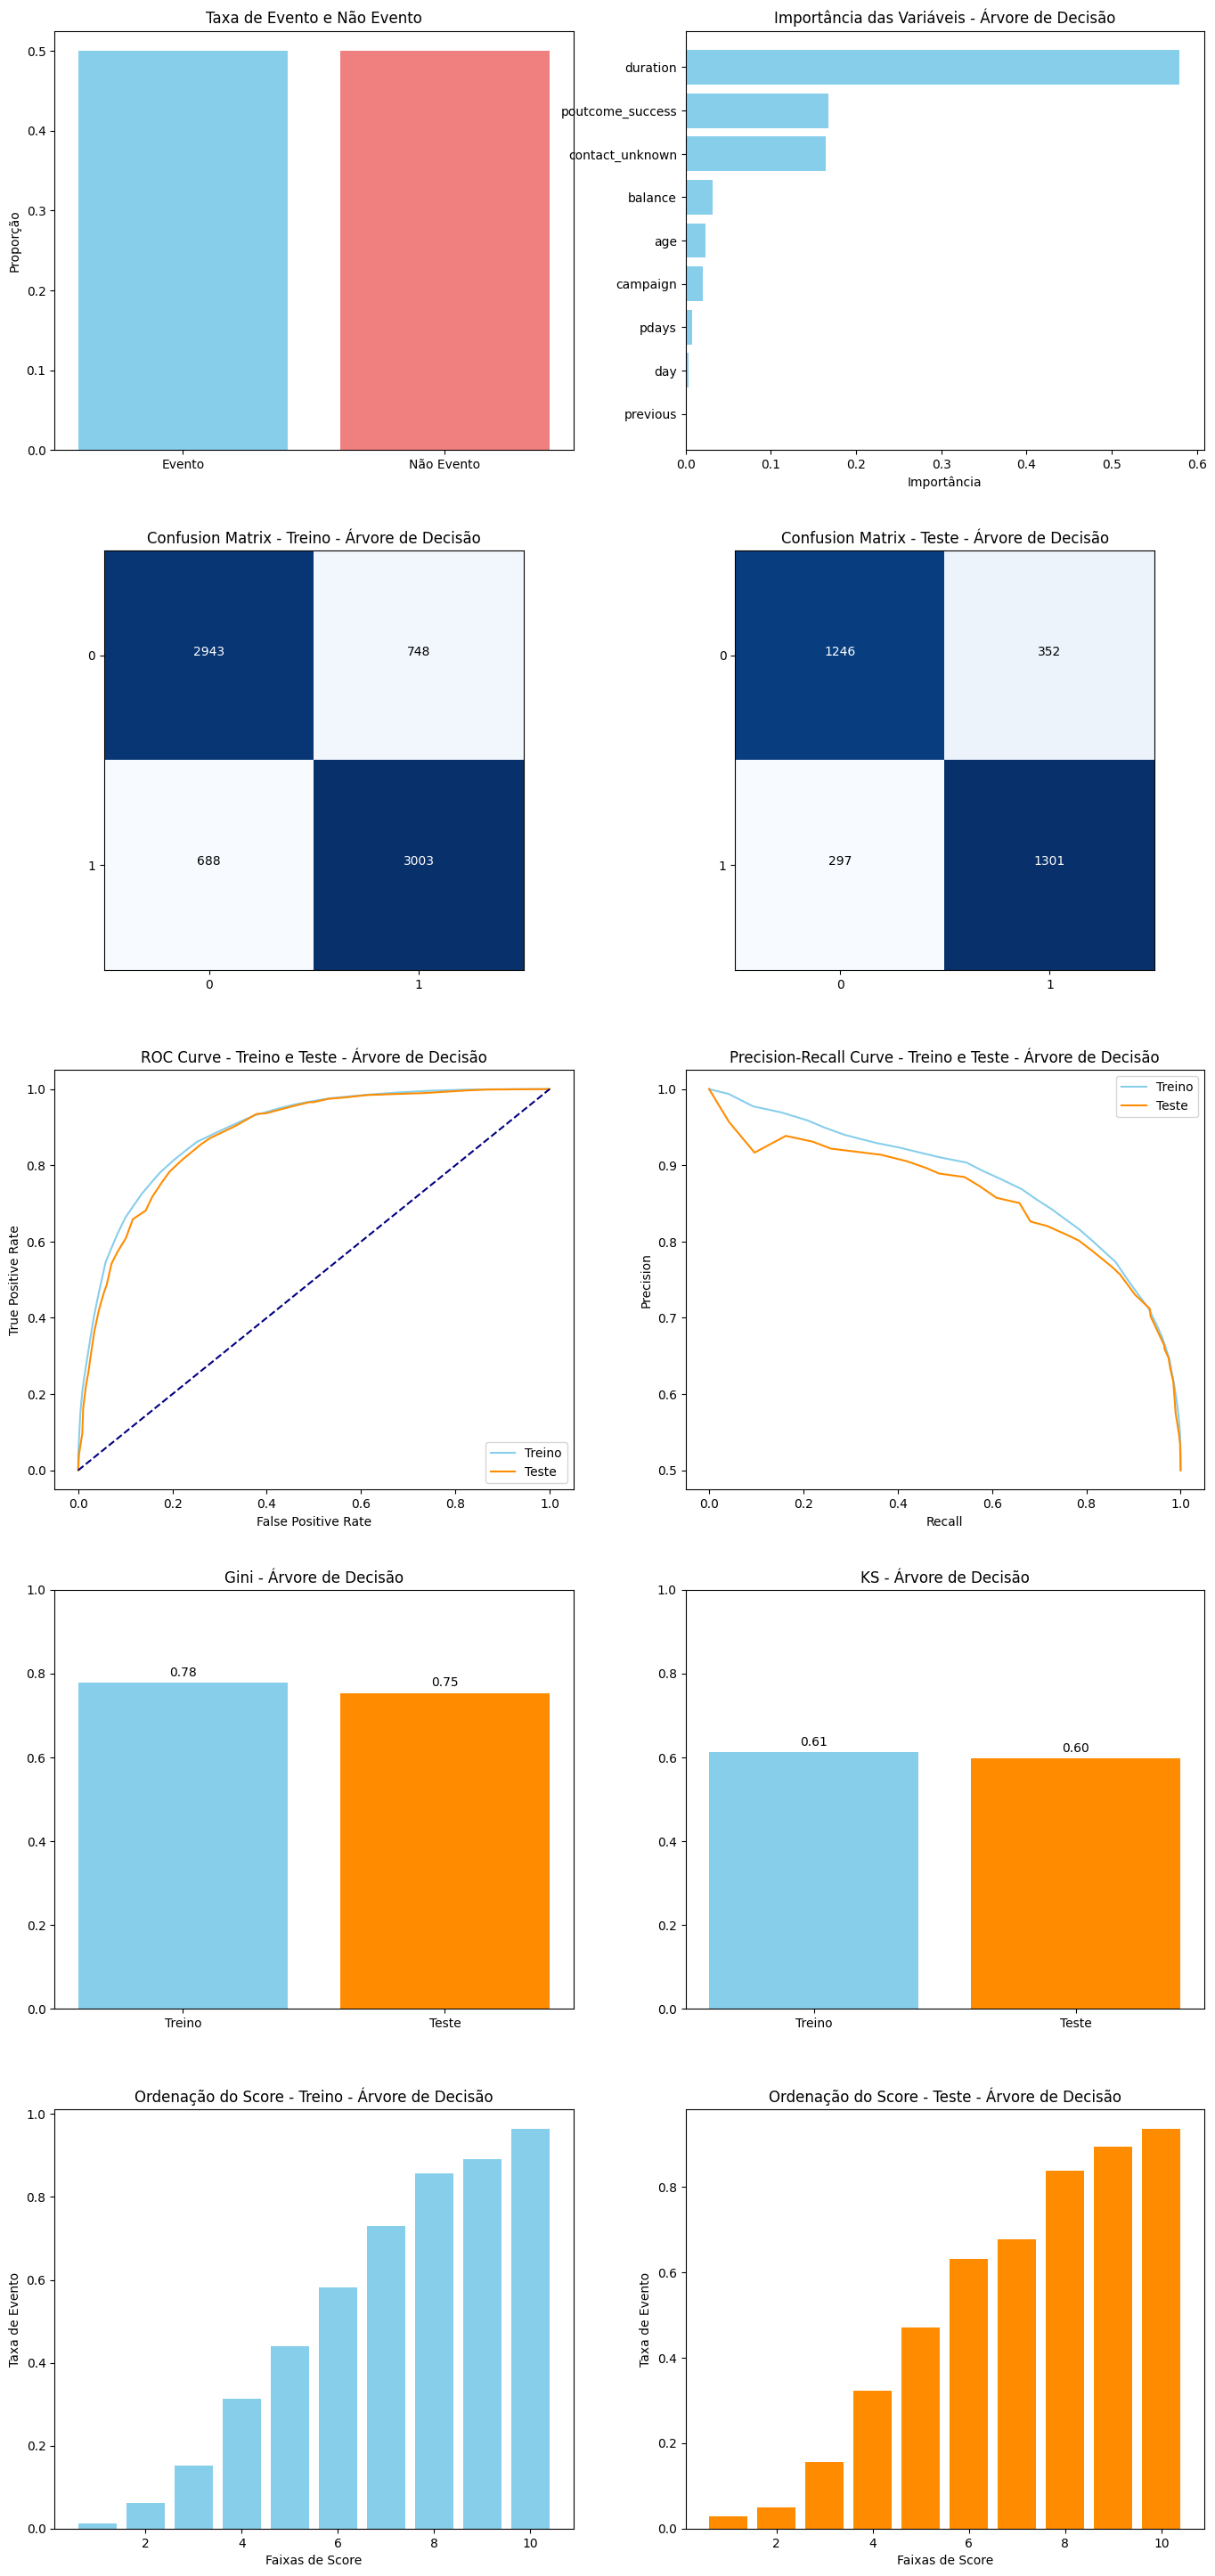

In [62]:
pod.avaliar_modelo(X_train, y_train, X_test, y_test, best_model_dt,nm_modelo='Árvore de Decisão')

## 3.3 Visualizando a melhor Árvore de Decisão obtida

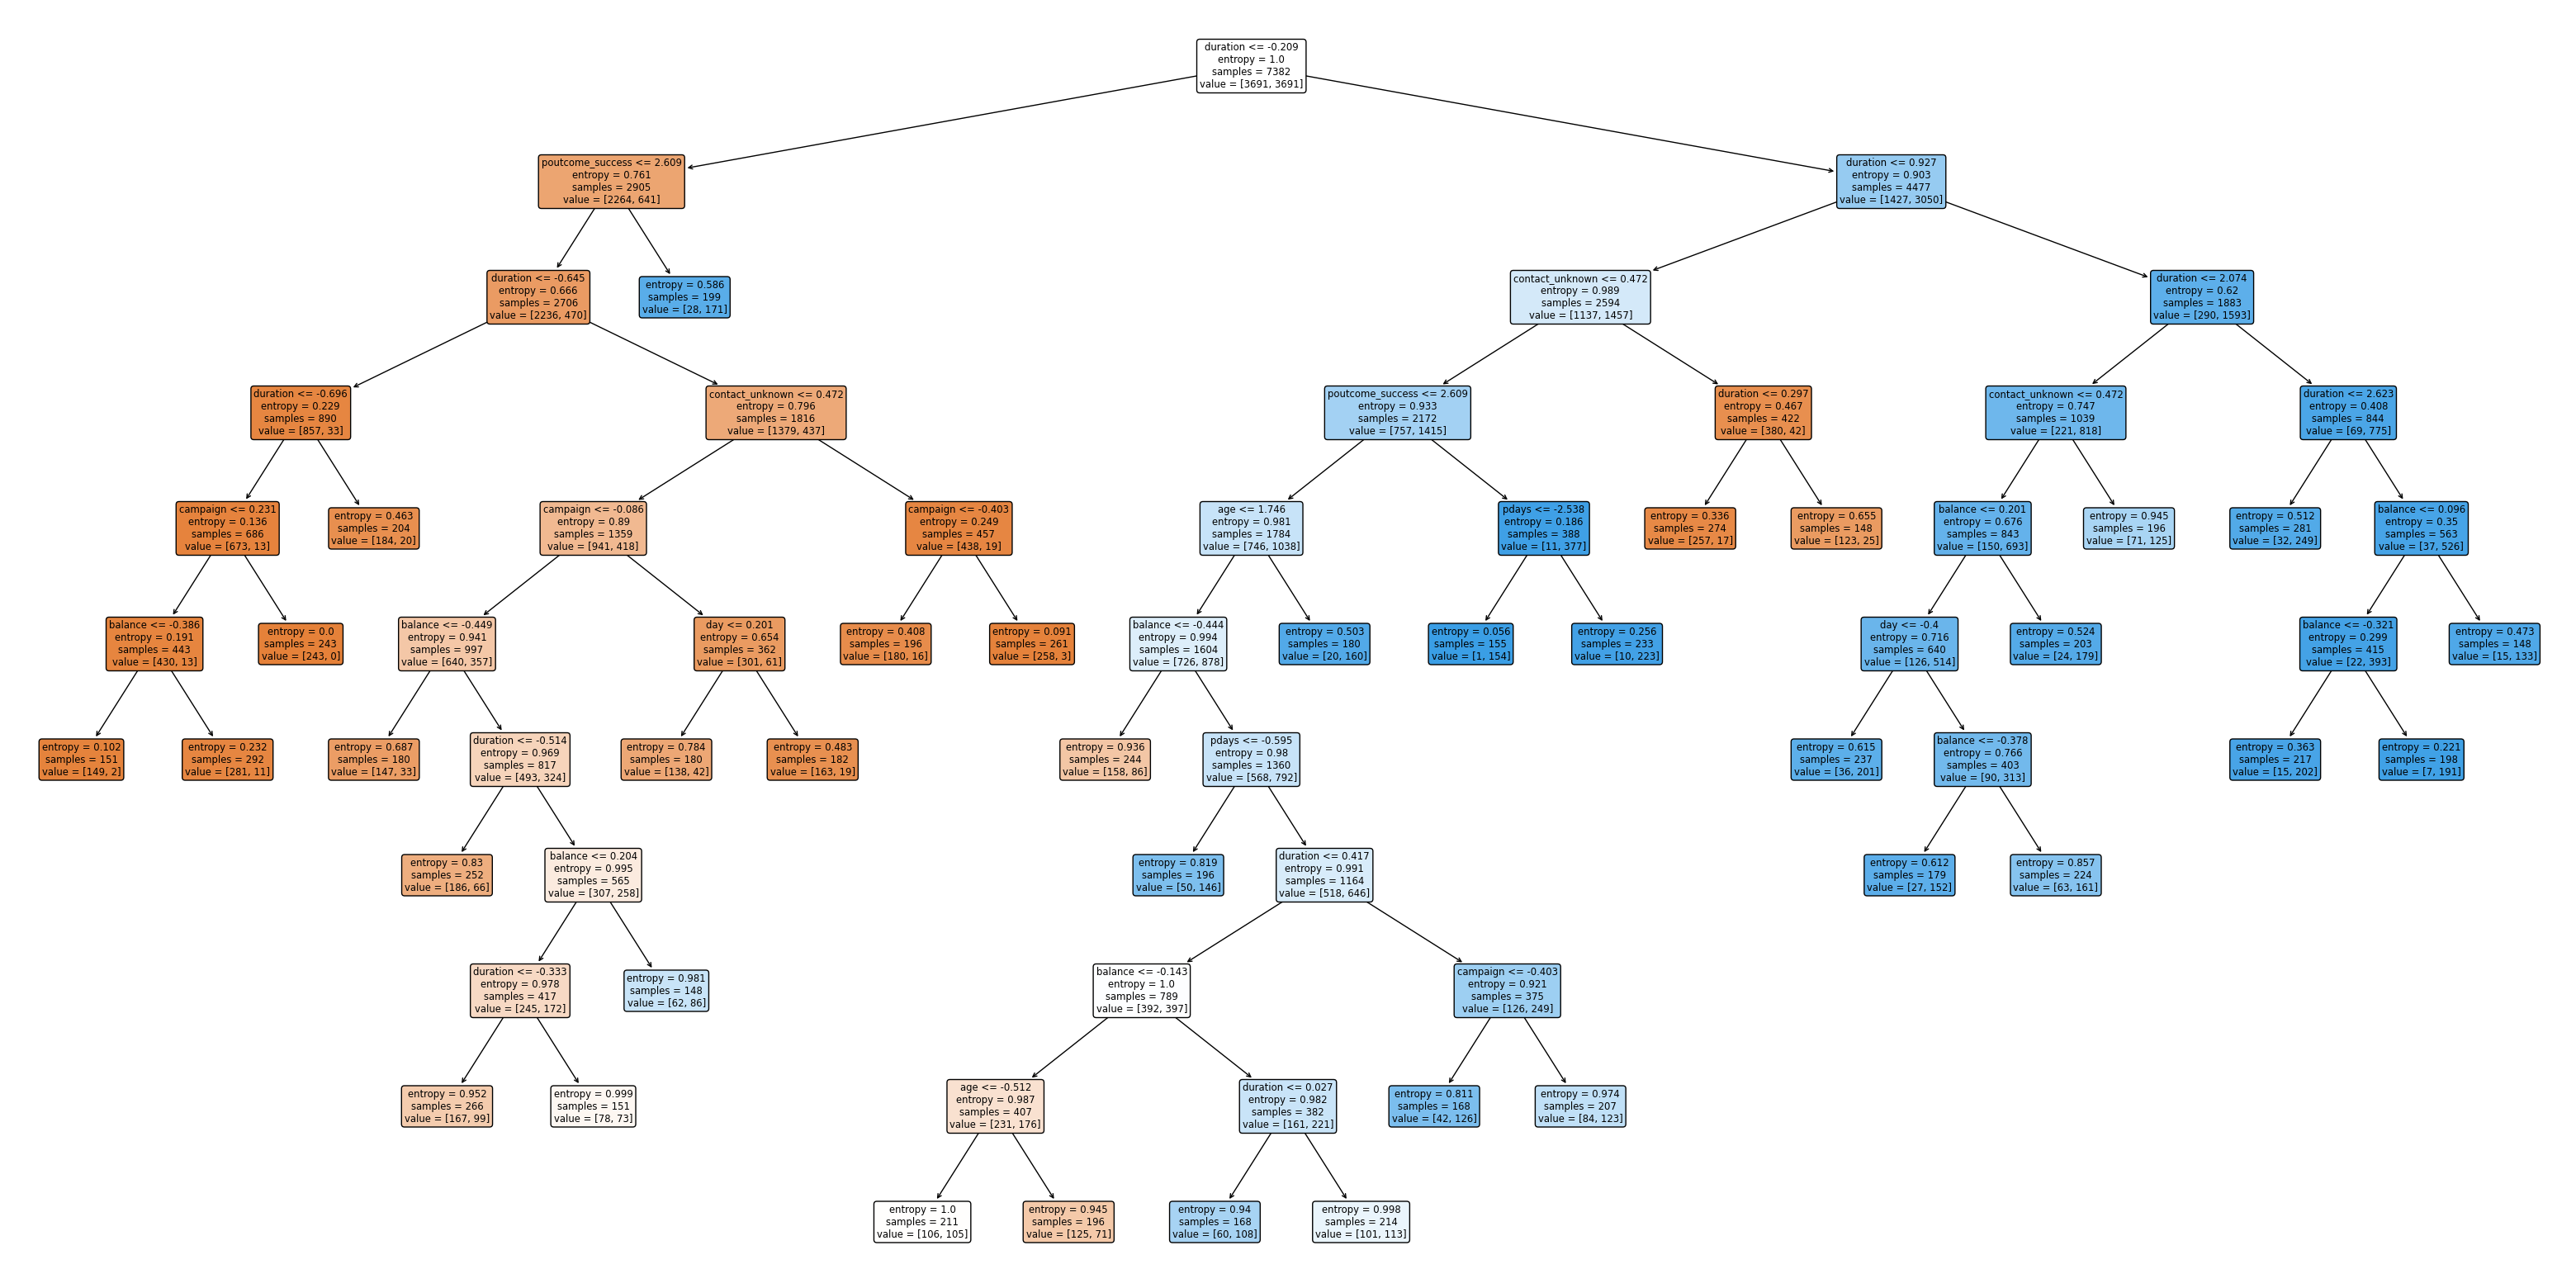

In [84]:
from sklearn.tree import plot_tree

# Visualizando a árvore
plt.figure(figsize=(40, 20))  # Tamanho da figura
plot_tree(best_model_dt,
          filled=True,        # Preencher os nós com cores
          feature_names=X_train.columns,  # Nome das features
          rounded=True)       # Nós arredondados
plt.show()

## 3.4 Visualização texto da Árvore de Decisão criada

In [86]:
from sklearn.tree import export_text

tree_rules = export_text(best_model_dt, feature_names=X_train.columns)
print(tree_rules)

|--- duration <= -0.21
|   |--- poutcome_success <= 2.61
|   |   |--- duration <= -0.65
|   |   |   |--- duration <= -0.70
|   |   |   |   |--- campaign <= 0.23
|   |   |   |   |   |--- balance <= -0.39
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- balance >  -0.39
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- campaign >  0.23
|   |   |   |   |   |--- class: 0
|   |   |   |--- duration >  -0.70
|   |   |   |   |--- class: 0
|   |   |--- duration >  -0.65
|   |   |   |--- contact_unknown <= 0.47
|   |   |   |   |--- campaign <= -0.09
|   |   |   |   |   |--- balance <= -0.45
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- balance >  -0.45
|   |   |   |   |   |   |--- duration <= -0.51
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- duration >  -0.51
|   |   |   |   |   |   |   |--- balance <= 0.20
|   |   |   |   |   |   |   |   |--- duration <= -0.33
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |  

# 4. **Modelo de Classificação:** Regressão Logística (*Logistic Regression*)

## 4.1 Treina o modelo e escolhe melhor ajuste

In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import numpy as np

# Definindo o modelo
model = LogisticRegression(max_iter=100)
model_sgs = LogisticRegression(max_iter=100)

# penalty='l2', # Tipo de regularização: 'l1', 'l2', 'elasticnet', 'none'
# dual=False, # Formulação primal e dual do problema de otimização da regressão logística, sendo recomendado manter como False quando temos mais amostras do que Variáveis
# tol=0.0001, # Tolerância para critério de parada.
# C=1.0, # Inverso da força de regularização; deve ser um valor flutuante positivo. Como valores menores, especifica uma regularização mais forte.
# fit_intercept=True, # Especifica se uma constante (ou seja, viés ou interceptação) deve ser adicionada à função de decisão.
# intercept_scaling=1, # Útil apenas quando o solver 'liblinear' é usado e self.fit_intercept é definido como True.
# class_weight=None, # Pesos associados às classes. Se não for fornecido, todas as classes são supostas ter peso um.
# random_state=None, # Semente usada pelo gerador de números aleatórios.
# solver='lbfgs', # Algoritmo a ser usado no problema de otimização: {'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'}, padrão='lbfgs'
# max_iter=100, # Número máximo de iterações para os solvers convergirem.
# multi_class='auto', # Se a opção escolhida for 'ovr', então um problema binário é ajustado para cada rótulo. Para 'multinomial', a perda minimizada é a perda multinomial ajustando todo o conjunto de dados de uma vez.
# verbose=0, # Para o solver 'liblinear' e 'lbfgs', defina o valor para qualquer inteiro positivo para classificar a verbosidade.
# warm_start=False, # Quando definido como True, reutiliza a solução da chamada anterior para ajustar como inicialização, caso contrário, apenas apaga a solução anterior.
# l1_ratio=None # O valor de Elastic-Net mixing parameter, com 0 <= l1_ratio <= 1. Somente usado se penalty='elasticnet'.


# Definindo os parâmetros para o grid search
param_grid = {
    'penalty':['l1','l2'],
    'tol':[0.00001,0.0001,0.001],
    'C': [1.0, 2.0],
    'solver':['liblinear', 'saga'],
    'class_weight': [None, 'balanced', {0: 1, 1: 2}, {0: 2, 1: 1}]
}



# Calculando a quantidade total de modelos que serão treinados
num_models = len(param_grid['penalty']) * len(param_grid['tol']) * len(param_grid['C']) * len(param_grid['solver']) * 5  # 5 é o número de folds na validação cruzada (cv)
print(f"Total de Modelos a serem Treinados: {num_models}")

# Definindo o objeto GridSearchCV
grid = GridSearchCV(model,
                    param_grid,
                    cv=5,
                    scoring='roc_auc',  # 'accuracy' 'precision' 'recall' 'f1'
                    n_jobs=-1)

# Treinando o modelo com o grid search
grid.fit(X_train, y_train)

# treinando modelo sem grid search para comparra
model_sgs.fit(X_train, y_train)

# Exibindo os melhores parâmetros encontrados pelo grid search
print("Melhores Parâmetros: ", grid.best_params_)

# Exibindo a melhor pontuação (score) atingida pelo modelo com os melhores parâmetros
print("Melhor AUC: ", grid.best_score_)

# Utilizando o melhor modelo para fazer previsões
predictions = grid.best_estimator_.predict(X_test)

predprob = grid.best_estimator_.predict_proba(X_test)

gini_n = round(pod.gini_normalizado(y_test, predprob[:, 1]),2)
print('Gini normalizado --> ',gini_n)

best_model_rl = grid.best_estimator_

Total de Modelos a serem Treinados: 120
Melhores Parâmetros:  {'C': 1.0, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.001}
Melhor AUC:  0.8768971026985796
Gini normalizado -->  0.74


## 4.2 Apresenta métricas do melhor ajuste de Modelo

/content/drive/MyDrive/PoD Academy/modelos/Hackaton_DS_2023/PoD Framework/pod_academy_functions.py:245: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  decile_analysis = y_test.groupby(deciles).mean()
/content/drive/MyDrive/PoD Academy/modelos/Hackaton_DS_2023/PoD Framework/pod_academy_functions.py:256: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  decile_analysis_train = y_train.groupby(deciles_train).mean()


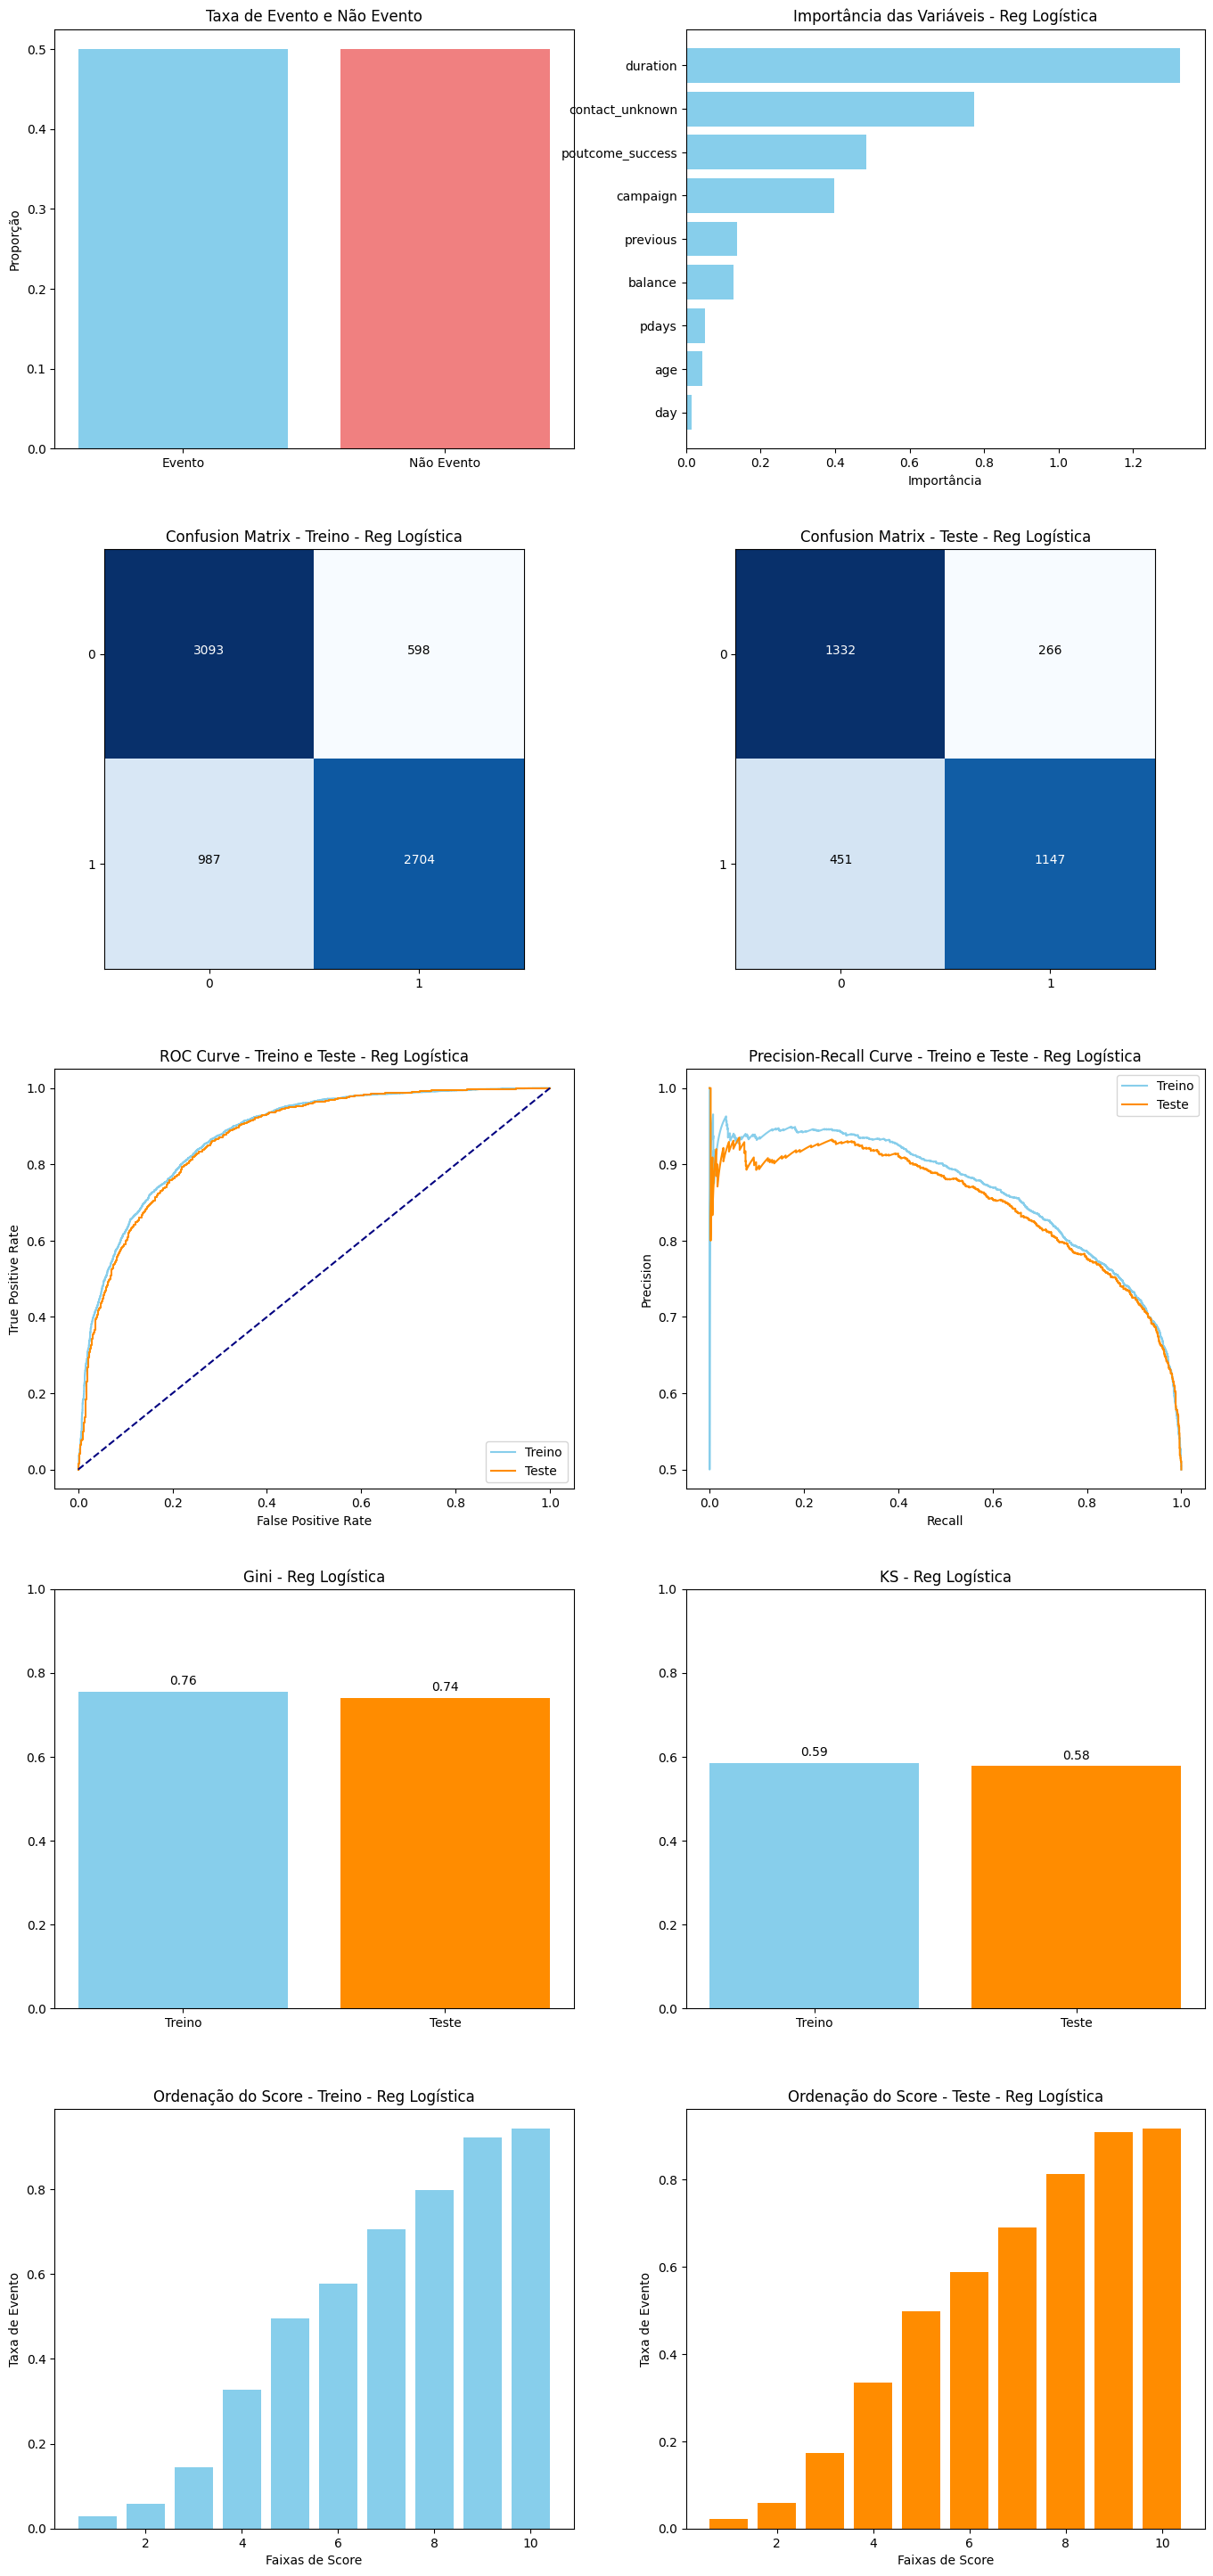

In [64]:
pod.avaliar_modelo(X_train, y_train, X_test, y_test, model_sgs,nm_modelo='Reg Logística')

## 4.3 Visualizando a melhor Regressão Logística obtida

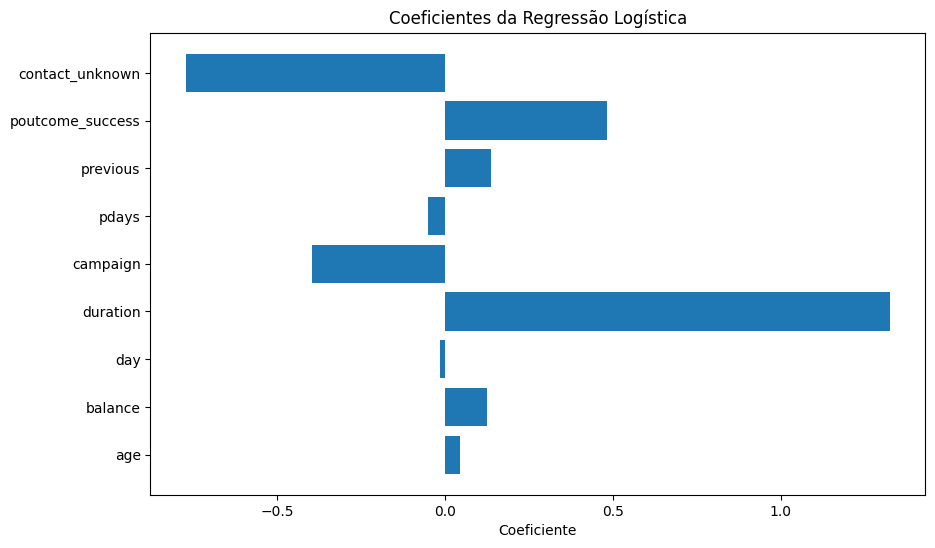

In [87]:
# Extraindo os coeficientes e os nomes das features
coef = best_model_rl.coef_[0]
features = X_train.columns

# Visualizando os coeficientes
plt.figure(figsize=(10, 6))
plt.barh(features, coef)
plt.xlabel("Coeficiente")
plt.title("Coeficientes da Regressão Logística")
plt.show()

# 5. **Modelo de Classificação:** *Random Forrest*

## 5.1 Treina o modelo e escolhe melhor ajuste

In [65]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np

# Definindo o modelo
model = RandomForestClassifier()

# n_estimators=100,  # Número de árvores na floresta.
# criterion='gini',  # Função para medir a qualidade de uma divisão ("gini" ou "entropy").
# max_depth=None,  # Profundidade máxima das árvores. None significa que os nós são expandidos até ficarem puros.
# min_samples_split=2,  # Número mínimo de amostras necessárias para dividir um nó interno.
# min_samples_leaf=1,  # Número mínimo de amostras necessárias para estar em um nó folha.
# min_weight_fraction_leaf=0.0,  # Fração mínima ponderada da soma total de pesos necessária para estar em um nó folha.
# max_features='auto',  # Número de características a considerar ao procurar a melhor divisão.
# max_leaf_nodes=None,  # Número máximo de nós folha.
# min_impurity_decrease=0.0,  # Um nó será dividido se a divisão induzir a uma diminuição da impureza maior ou igual a este valor.
# bootstrap=True,  # Se as amostras de bootstrap são usadas ao construir árvores.
# oob_score=False,  # Se usar amostras out-of-bag para estimar a precisão generalizada.
# n_jobs=None,  # Número de jobs a serem executados em paralelo para ajuste e previsão. -1 significa usar todos os processadores.
# random_state=None,  # Controla a aleatoriedade do bootstrap e da seleção de features.
# verbose=0,  # Controla a verbosidade do processo de treinamento.
# warm_start=False,  # Reutiliza a solução da chamada anterior para ajustar e adicionar mais estimadores ao ensemble.
# class_weight=None  # Pesos associados às classes. Pode ser "balanced", "balanced_subsample" ou um dicionário com os pesos.


# Definindo os parâmetros para o grid search
param_grid = {
    'n_estimators': [10, 50,100],
    'max_depth': [2, 3, 5],
    'min_samples_split': [0.001, 0.01],
    'min_samples_leaf': [2, 0.01],
    'bootstrap': [True, False],
    # 'max_features': ['auto', 'sqrt', 'log2']
}

# Definindo o objeto GridSearchCV
grid = GridSearchCV(model,
                    param_grid,
                    cv=5,
                    verbose=2,
                    scoring='roc_auc',  # 'accuracy' 'precision' 'recall' 'f1'
                    n_jobs=-1)

# Treinando o modelo com o grid search
grid.fit(X_train, y_train)

# Exibindo os melhores parâmetros encontrados pelo grid search
print("Melhores Parâmetros: ", grid.best_params_)

# Exibindo a melhor pontuação (score) atingida pelo modelo com os melhores parâmetros
print("Melhor AUC: ", grid.best_score_)

# Utilizando o melhor modelo para fazer previsões
predictions = grid.best_estimator_.predict(X_test)

predprob = grid.best_estimator_.predict_proba(X_test)

gini_n = round(pod.gini_normalizado(y_test, predprob[:, 1]),2)
print('Gini normalizado --> ',gini_n)

best_model_rf = grid.best_estimator_

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Melhores Parâmetros:  {'bootstrap': True, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 0.01, 'n_estimators': 100}
Melhor AUC:  0.8886002428431382
Gini normalizado -->  0.77


## 5.2 Apresenta métricas do melhor ajuste de Modelo

/content/drive/MyDrive/PoD Academy/modelos/Hackaton_DS_2023/PoD Framework/pod_academy_functions.py:245: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  decile_analysis = y_test.groupby(deciles).mean()
/content/drive/MyDrive/PoD Academy/modelos/Hackaton_DS_2023/PoD Framework/pod_academy_functions.py:256: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  decile_analysis_train = y_train.groupby(deciles_train).mean()


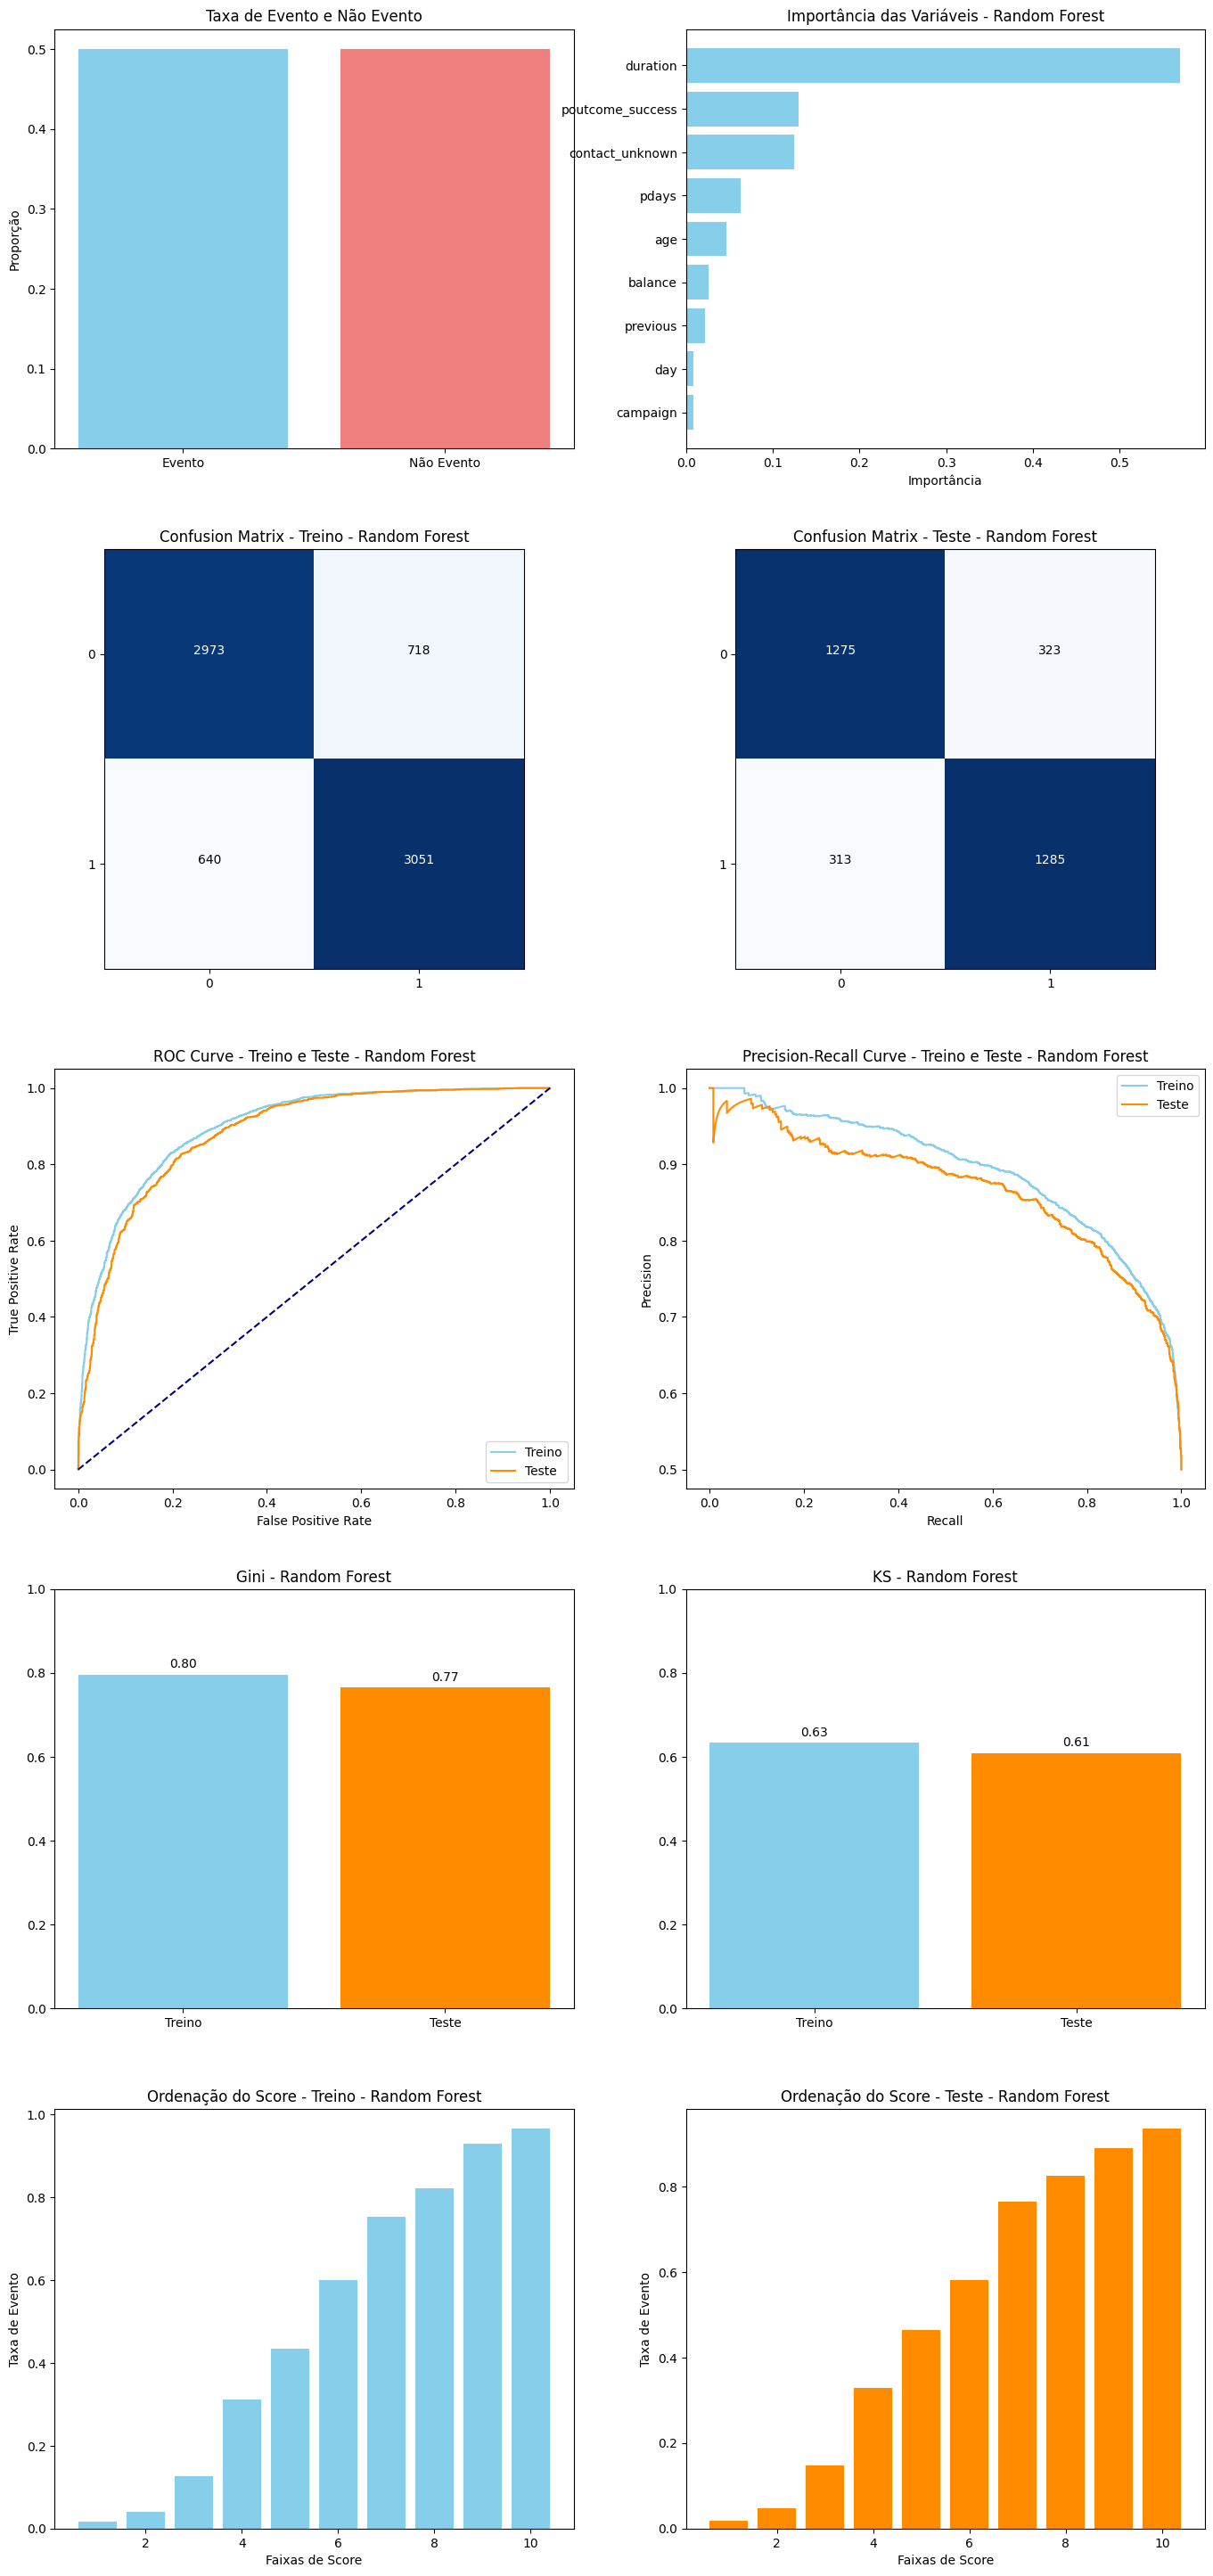

In [66]:
pod.avaliar_modelo(X_train, y_train, X_test, y_test, best_model_rf,nm_modelo='Random Forest')

# 6. **Modelo de Classificação:** *lightGBM*

## 6.1 Treina o modelo e escolhe melhor ajuste

In [67]:
pip install "dask[dataframe]"

INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.9/241.9 kB 4.5 MB/s eta 0:00:00


In [68]:
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
import numpy as np

# Definindo o modelo
model = lgb.LGBMClassifier()


# Definindo os parâmetros para o grid search
param_grid = {
    'max_depth' : [3,5,7],
    'num_leaves': [5, 31],
    'reg_alpha': [0.1, 0.5],
    'min_data_in_leaf': [2, 5],
    'lambda_l1': [0, 1, 1.5],
    'lambda_l2': [0, 1]
}

# Definindo o objeto GridSearchCV
grid = GridSearchCV(model,
                    param_grid,
                    cv=5,
                    verbose=2,
                    scoring='roc_auc',  # 'accuracy' 'precision' 'recall' 'f1'
                    n_jobs=-1)

# Treinando o modelo com o grid search
grid.fit(X_train, y_train)


# Exibindo os melhores parâmetros encontrados pelo grid search
print("Melhores Parâmetros: ", grid.best_params_)

# Exibindo a melhor pontuação (score) atingida pelo modelo com os melhores parâmetros
print("Melhor AUC: ", grid.best_score_)

# Utilizando o melhor modelo para fazer previsões
predictions = grid.best_estimator_.predict(X_test)

predprob = grid.best_estimator_.predict_proba(X_test)

gini_n = round(pod.gini_normalizado(y_test, predprob[:, 1]),2)
print('Gini normalizado --> ',gini_n)

best_model_lightgbm = grid.best_estimator_

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.1 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.1 will be ignored. Current value: lambda_l1=1
[LightGBM] [Info] Number of positive: 3691, number of negative: 3691
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000816 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Lig

## 6.2 Apresenta métricas do melhor ajuste de Modelo

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.1 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.1 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] lambda_l2 is set=1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1
[LightGBM] [Warning] lambda_l1 is set=1, reg_alpha=0.1 will be ignored. Current value: lambda_l1=1
[LightGBM] [Warning] min_data_in_leaf is se

/content/drive/MyDrive/PoD Academy/modelos/Hackaton_DS_2023/PoD Framework/pod_academy_functions.py:245: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  decile_analysis = y_test.groupby(deciles).mean()
/content/drive/MyDrive/PoD Academy/modelos/Hackaton_DS_2023/PoD Framework/pod_academy_functions.py:256: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  decile_analysis_train = y_train.groupby(deciles_train).mean()


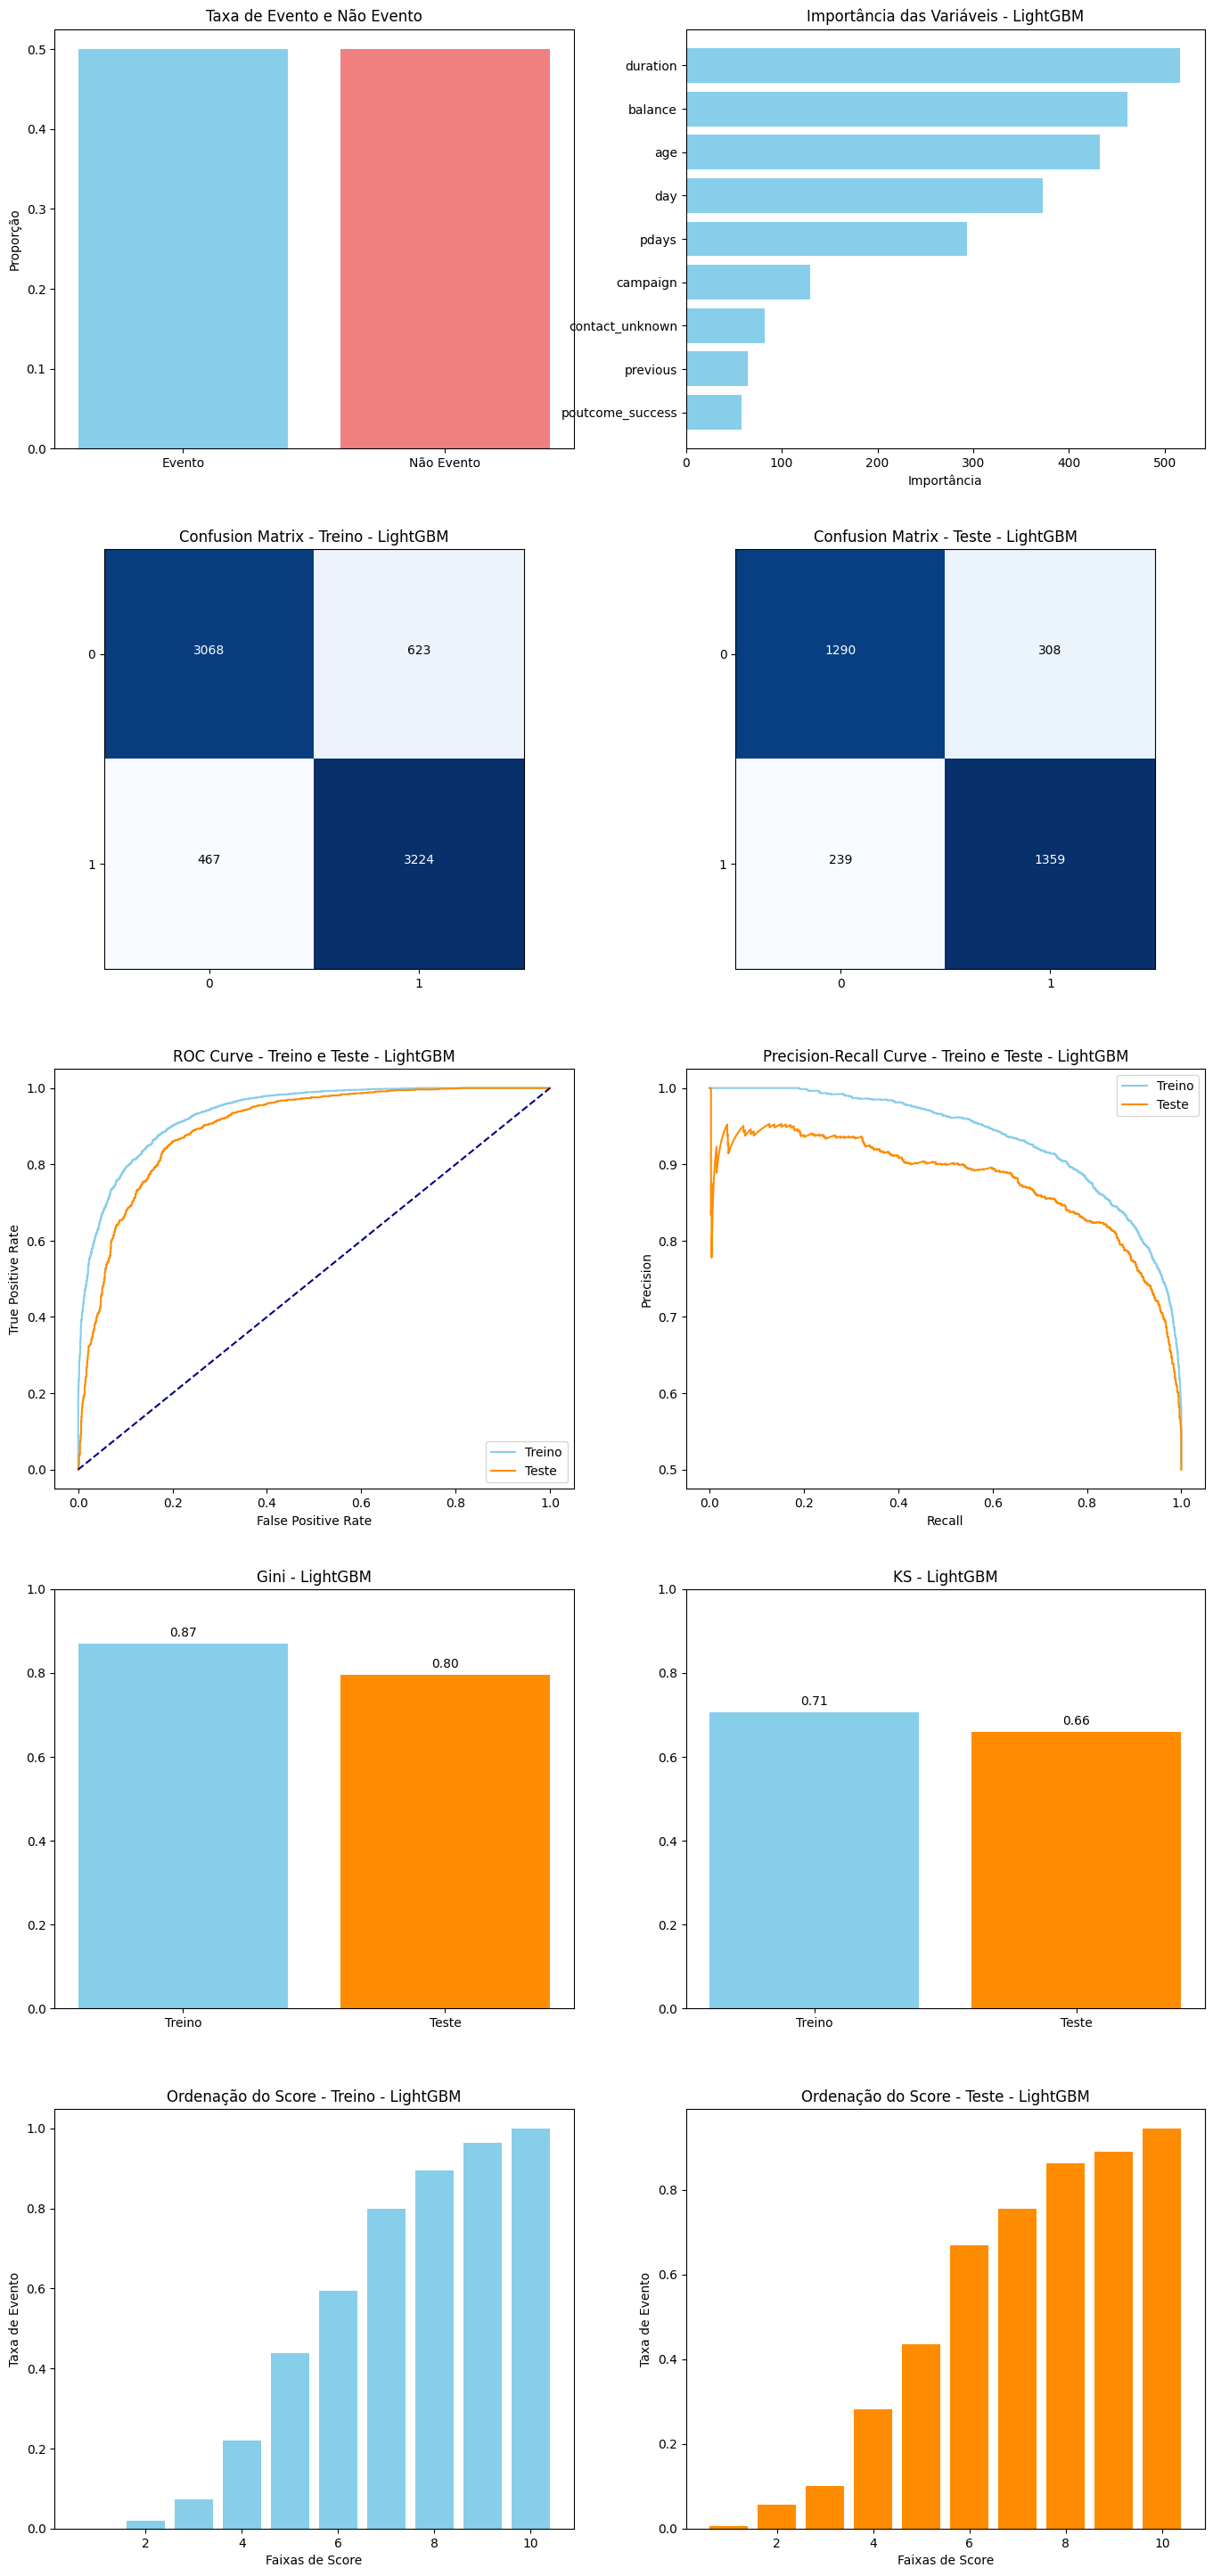

In [69]:
pod.avaliar_modelo(X_train, y_train, X_test, y_test, best_model_lightgbm,nm_modelo='LightGBM')

# 7. Salvando artefatos dos modelos

In [70]:
import pickle

# Vá para o folder de modelos
%cd /content/drive/MyDrive/Kaggle/Bank\ Marketing/03\ models

with open('best_model_dt.pkl', 'wb') as file:
  pickle.dump(best_model_dt, file)

with open('best_model_rl.pkl', 'wb') as file:
  pickle.dump(best_model_rl, file)

with open('best_model_rf.pkl', 'wb') as file:
  pickle.dump(best_model_rf, file)

with open('best_model_lightgbm.pkl', 'wb') as file:
  pickle.dump(best_model_lightgbm, file)

/content/drive/MyDrive/Kaggle/Bank Marketing/03 models


In [72]:
print(best_model_dt)
print(best_model_rl)
print(best_model_rf)
print(best_model_lightgbm)

DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=0.02,
                       min_samples_split=0.008, random_state=42)
LogisticRegression(penalty='l1', solver='liblinear', tol=0.001)
RandomForestClassifier(max_depth=5, min_samples_leaf=2, min_samples_split=0.01)
LGBMClassifier(lambda_l1=1, lambda_l2=1, max_depth=5, min_data_in_leaf=5,
               reg_alpha=0.1)
